In [2]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
%matplotlib inline

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from multicam.mah import get_mah

# Data

In [6]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.90, 
                   cutoff_particle=0.90) # not strict

In [7]:
len(mah_data['cat'])

9990

In [8]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(9990,) (9990,) (9990, 100) (9990, 178) (178,) (100,)


# Extract MM scales, make histogram

In [8]:
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices):
#         f_sub_name = f'f_sub_a{idx}'
        m2_name = f'm2_a{idx}'
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
#         cpg_ratio = cat[cpg_name][i] / cat[mvir_name][i]
#         merger_ratio_inst[i, j] = np.nanmax((m2_ratio, cpg_ratio))
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
#         cpg_ratio = cat[cpg_name][i] / cat['mvir']
#         merger_ratio_present[i, j] = np.nanmax((m2_ratio, cpg_ratio))
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# now construct scale of last MM (at present day) as a function fo different thresholds
# Mu = np.linspace(0.1, 1, num=10)
 # ROCKSTAR / CONSISTENT_TREES definition is ratio / (1 + ratio)
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
cutoff_scales= [0.25, 0.3, 0.4, 0.8] # cutoffs for 50 particles (phil)
scale_of_last_MM_inst = np.zeros((len(cat), len(Mu)))
for i in range(len(cat)):
    for k, mu in enumerate(Mu):
        MM_indices = np.where(merger_ratio_inst[i] > mu)[0]
        if len(MM_indices) > 0 and scales[MM_indices[-1]] >= cutoff_scales[k]: 
            scale_of_last_MM_inst[i, k] = scales[MM_indices[-1]]
        else: 
            scale_of_last_MM_inst[i, k] = np.nan


In [10]:
# now construct scale of last MM (at present day) as a function fo different thresholds
# Mu = np.linspace(0.1, 1, num=10)
# ROCKSTAR / CONSISTENT_TREES definition is ratio / (1 + ratio)
Mu = [0.3/1.3, 0.1 / 1.1 , 1/30 / (1 + 1/30), 0.01 / 1.01] 
cutoff_scales= [0.25, 0.3, 0.4, 0.8] # cutoffs for 50 particles (phil)
scale_of_last_MM_present = np.zeros((len(cat), len(Mu)))
for i in range(len(cat)):
    for k, mu in enumerate(Mu):
        MM_indices = np.where(merger_ratio_present[i] > mu)[0]
        if len(MM_indices) > 0 and scales[MM_indices[-1]] >= cutoff_scales[k]: 
            scale_of_last_MM_present[i, k] = scales[MM_indices[-1]]
        else: 
            scale_of_last_MM_present[i, k] = np.nan


Text(0.5, 0, '\\rm Scale of Last MM (instantaneous mass)')

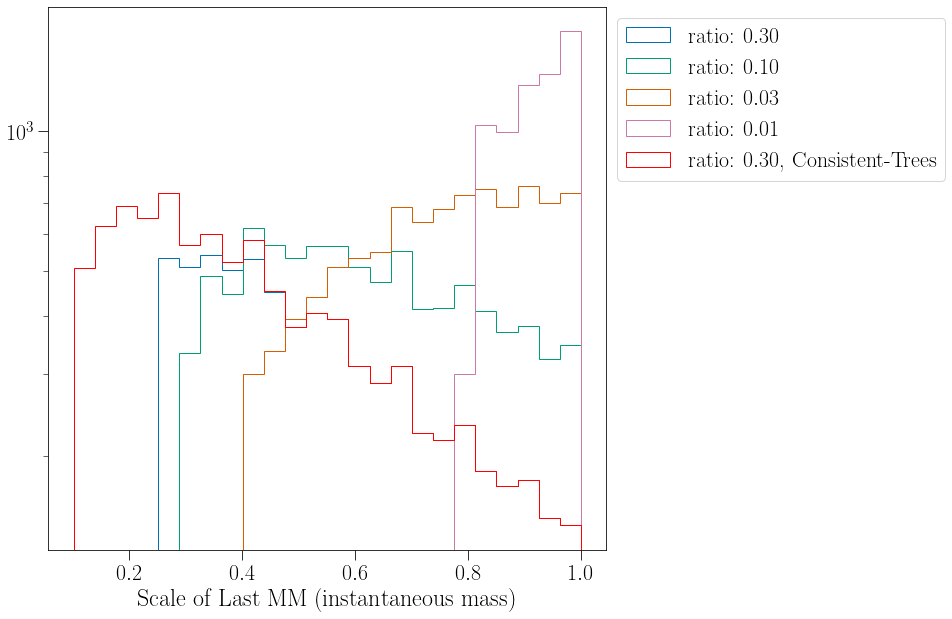

In [68]:
plt.figure(figsize=(10,10))
bins = np.linspace(np.min(scales), np.max(scales), 25)
for k, cutoff in enumerate(cutoff_scales): 
    plt.hist(scale_of_last_MM_inst[:, k], histtype='step', label=f'\\rm ratio: ${Mu[k]/(1-Mu[k]):.2f}$', bins=bins)
    
# ROCKSTAR 
plt.hist(cat['scale_of_last_mm'], histtype='step', label=f'\\rm ratio: $0.30$, Consistent-Trees', bins=bins, color='r')

# formatting
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.yscale('log')
plt.xlabel("\\rm Scale of Last MM (instantaneous mass)")

Text(0.5, 0, '\\rm Scale of Last MM (present-day mass)')

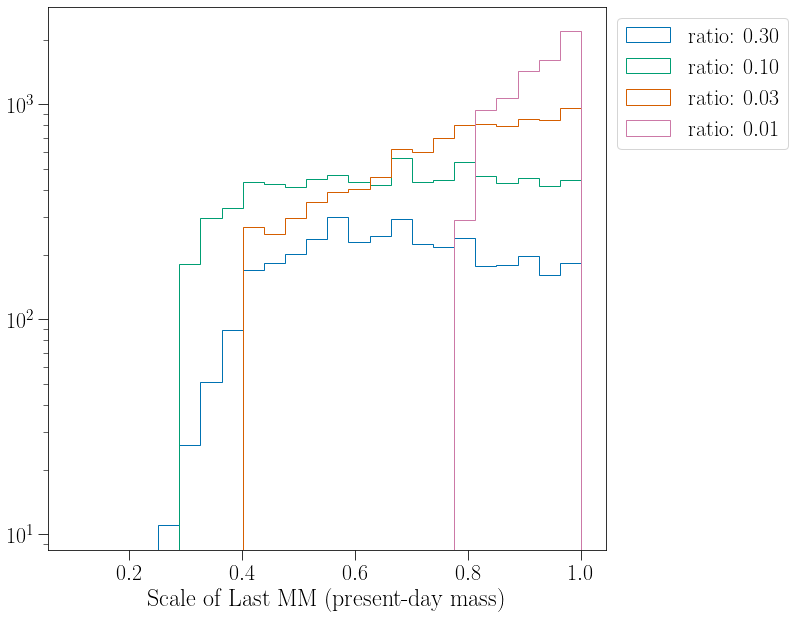

In [20]:
plt.figure(figsize=(10,10))
bins = np.linspace(np.min(scales), np.max(scales), 25)
for k, cutoff in enumerate(cutoff_scales): 
    plt.hist(scale_of_last_MM_present[:, k], histtype='step', label=f'\\rm ratio: ${Mu[k]/(1-Mu[k]):.2f}$', bins=bins)
    
# formatting
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.yscale('log')
plt.xlabel("\\rm Scale of Last MM (present-day mass)")


## Direct ROCKSTAR comparison

6666 7062
2393
6131


Text(0, 0.5, '\\rm Estimate')

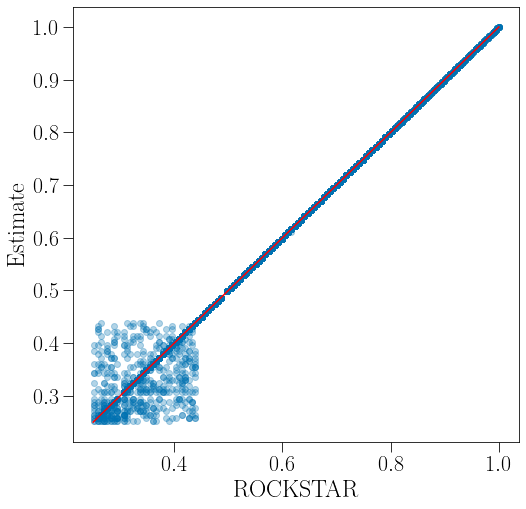

In [69]:
plt.figure(figsize=(8,8))
keep1 = ~np.isnan(scale_of_last_MM_inst[:, 0])
keep2 = cat['scale_of_last_mm'] > 0.25
print(keep1.sum(), keep2.sum())
print(np.sum( (keep1 == keep2) & (keep1 == False) & (keep2 == False)))
keep = keep1 & keep2
print(keep.sum())
plt.scatter(cat['scale_of_last_mm'][keep], scale_of_last_MM_inst[:, 0][keep], alpha=0.3)
plt.plot([0.25, 1],[0.25, 1], c='r')
plt.xlabel(r"\rm ROCKSTAR", size=24)
plt.ylabel(r"\rm Estimate", size=24)

## Check Discrepancy at small scales

In [12]:
scales

array([0.10235, 0.10835, 0.11435, 0.12035, 0.13235, 0.13835, 0.14435,
       0.15035, 0.15635, 0.16235, 0.16835, 0.17435, 0.18035, 0.18635,
       0.19235, 0.19835, 0.20235, 0.20435, 0.21035, 0.21635, 0.22235,
       0.22835, 0.23435, 0.24635, 0.25235, 0.25835, 0.26435, 0.27035,
       0.27635, 0.28235, 0.28835, 0.29435, 0.30635, 0.31235, 0.31835,
       0.32435, 0.33035, 0.33635, 0.34235, 0.34835, 0.35435, 0.36035,
       0.36635, 0.37235, 0.37835, 0.38435, 0.39035, 0.39635, 0.40235,
       0.40835, 0.41435, 0.42035, 0.42635, 0.43235, 0.43835, 0.44435,
       0.45035, 0.45635, 0.46235, 0.46835, 0.47435, 0.48035, 0.48635,
       0.49835, 0.50435, 0.51035, 0.51635, 0.52235, 0.52835, 0.53235,
       0.53835, 0.54435, 0.55035, 0.55635, 0.56235, 0.56835, 0.57435,
       0.58035, 0.58635, 0.59235, 0.59835, 0.60435, 0.61035, 0.61635,
       0.62235, 0.62835, 0.63435, 0.64035, 0.64635, 0.65235, 0.65835,
       0.66435, 0.67035, 0.67635, 0.68235, 0.68835, 0.69435, 0.70035,
       0.70635, 0.71

In [ ]:
weird_indx = np.where(cat['id']==3067645766)[0]
print(cat['coprog_mvir_a151'][weird_indx] / cat['mvir'][weird_indx])
print(cat['m2_a152'][weird_indx] / cat['mvir'][weird_indx])

0.3472413908746046


In [ ]:
weird_indx = np.where(cat['id']==3062514446)[0]
cat['coprog_mvir_a164'][weird_indx] / cat['mvir'][weird_indx]

0.37836205316596494


## Correlations with present day properties 

In [11]:
from multicam.correlations import spearmanr

In [23]:
mask_nan = ~np.isnan(scale_of_last_MM_inst[:, 0])
cvir = cat['cvir'][mask_nan]
xoff = cat['x0'][mask_nan]
eta = cat['t/|u|'][mask_nan]
spin = cat['spin_bullock'][mask_nan]
c_to_a = cat['c_to_a'][mask_nan]
mm_scales = scale_of_last_MM_inst[:, 0][mask_nan]
print(spearmanr(cvir, mm_scales))
print(spearmanr(xoff, mm_scales))
print(spearmanr(eta, mm_scales))
print(spearmanr(spin, mm_scales))
print(spearmanr(c_to_a, mm_scales))

-0.40269119601023273
0.4007221448208005
0.41558284666350304
0.42633569719825376
-0.4480812879001036


In [25]:
mask_nan = ~np.isnan(scale_of_last_MM_present[:, 0])
cvir = cat['cvir'][mask_nan]
xoff = cat['x0'][mask_nan]
eta = cat['t/|u|'][mask_nan]
spin = cat['spin_bullock'][mask_nan]
c_to_a = cat['c_to_a'][mask_nan]
mm_scales = scale_of_last_MM_present[:, 0][mask_nan]
print(spearmanr(cvir, mm_scales))
print(spearmanr(xoff, mm_scales))
print(spearmanr(eta, mm_scales))
print(spearmanr(spin, mm_scales))
print(spearmanr(c_to_a, mm_scales))

-0.555195424266474
0.6391132160663451
0.6528015852208361
0.45549695200361195
-0.6407532167499496


# Indicator and merger impact

In [9]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [10]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [11]:
np.min(scales)

0.18635

In [12]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)

In [13]:
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])